In [2]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [3]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [6]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - kl_loss: 3.7161 - reconstruction_loss: 395.6957 - total_loss: 399.4119 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 5.8951 - reconstruction_loss: 265.7735 - total_loss: 271.6686 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9506 - reconstruction_loss: 261.6170 - total_loss: 267.5675 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.0299 - reconstruction_loss: 259.2208 - total_loss: 265.2507 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0798 - reconstruction_loss: 258.2655 - total_loss: 264.34

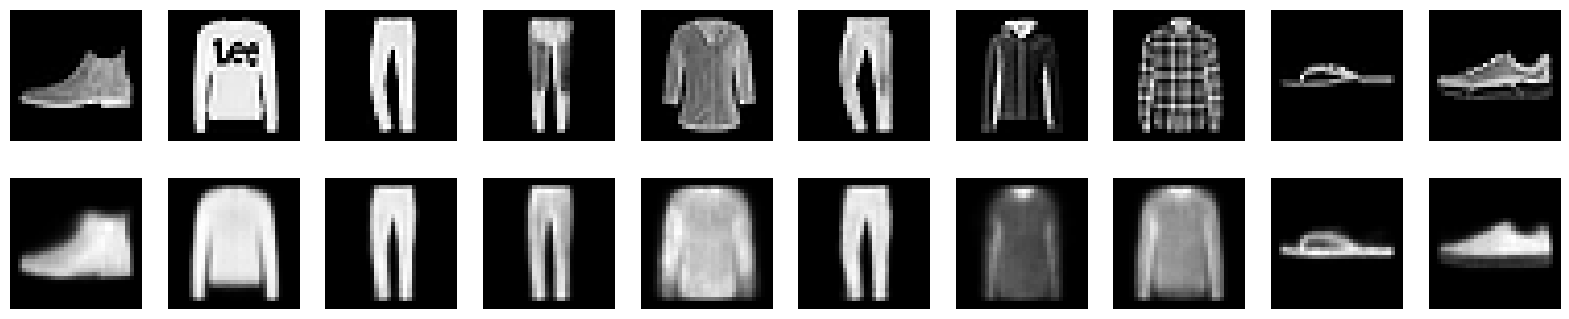

In [7]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


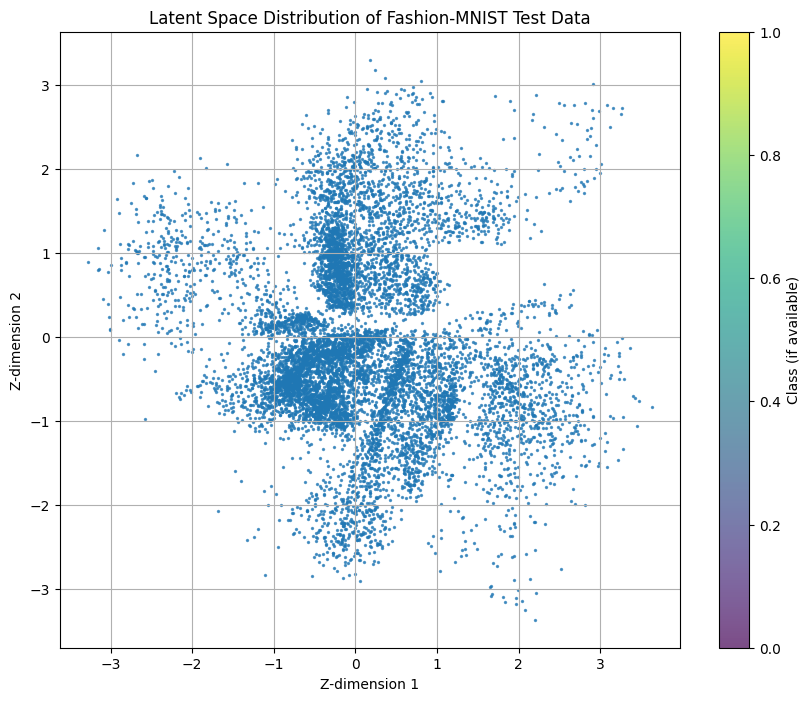

In [8]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [9]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [10]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 0.02793153  1.1262865 ]
 [-0.892976   -0.78131866]
 [ 2.1976242  -1.8682406 ]
 [ 1.8815762  -0.6546411 ]
 [-0.61986166 -0.11722656]]


## Visualize Latent Space Distribution by Class



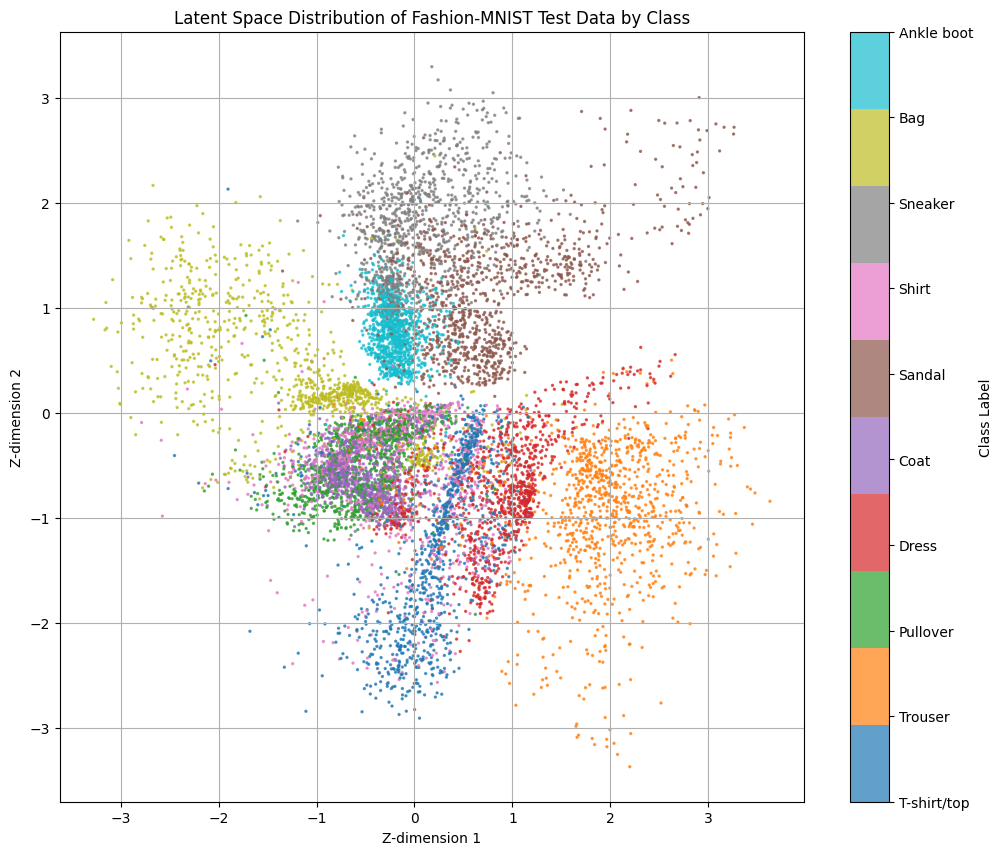

In [11]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

Melatih VAE... (Epochs 20)
Pelatihan VAE selesai.

--- 3. Latent Space Arithmetic (Fashion-MNIST) ---
Mean z for T-shirt/top (Label 0): [-0.02560988  1.1904697 ]
Mean z for Trouser (Label 1): [-1.7431744  1.2496393]
Mean z for Pullover (Label 2): [0.49706292 0.36009598]
Mean z for Dress (Label 3): [-0.79406714  0.7280663 ]
Mean z for Coat (Label 4): [0.4102139  0.50849646]
Mean z for Sandal (Label 5): [-0.86064374 -1.1917361 ]
Mean z for Shirt (Label 6): [0.24598202 0.52551526]
Mean z for Sneaker (Label 7): [-0.17354456 -1.9263777 ]
Mean z for Bag (Label 8): [ 1.1773548  -0.42968556]
Mean z for Ankle boot (Label 9): [ 0.15022005 -0.84368926]

Operasi: Sandal - Sneaker + Ankle Boot
Hasil Vektor Latent: [-0.5368792  -0.10904771]


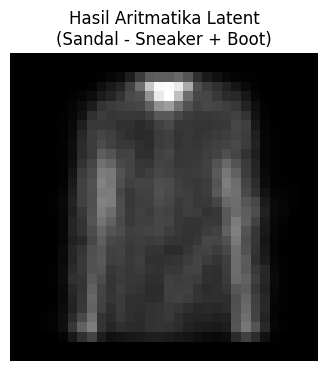


--- 4. Perbandingan Rekonstruksi (VAE vs Autoencoder) ---
Melatih Autoencoder (AE)... (Epochs 20)
Pelatihan AE selesai.


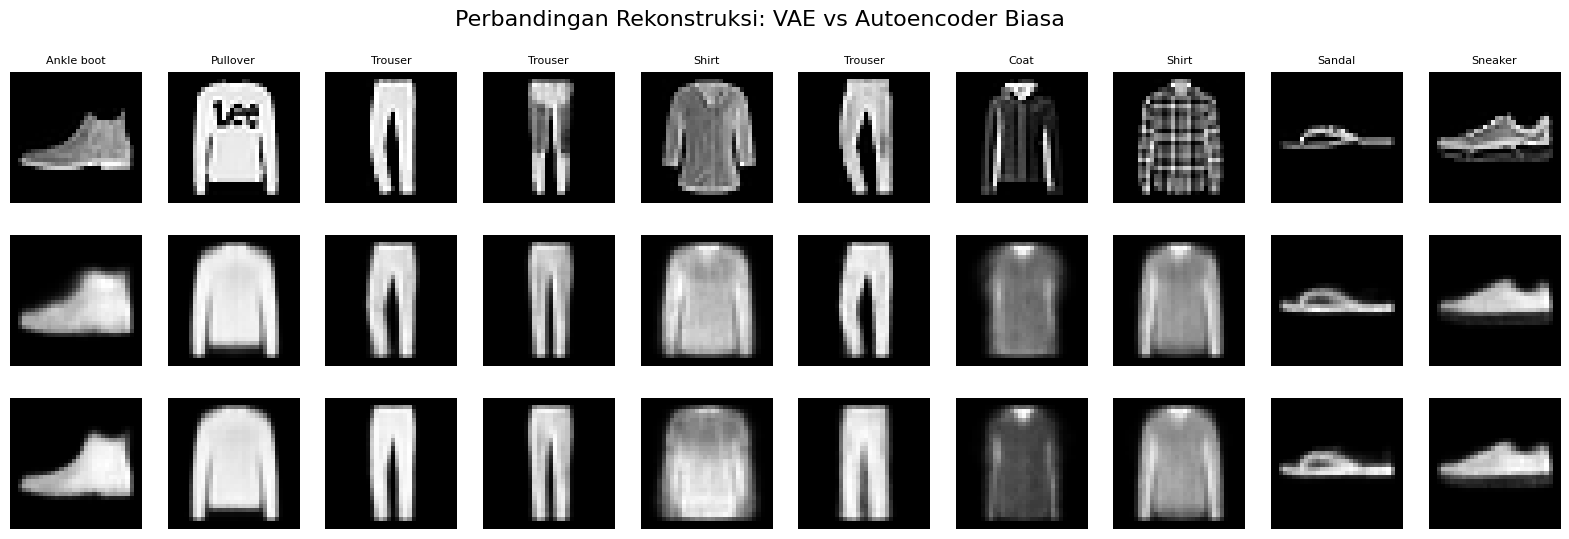


Penjelasan Hasil Perbandingan:
- **Autoencoder (AE) Biasa** cenderung menghasilkan rekonstruksi yang lebih tajam dan fokus pada detail, karena tujuannya hanya meminimalkan loss rekonstruksi.
- **Variational Autoencoder (VAE)** cenderung menghasilkan rekonstruksi yang sedikit lebih 'buram' atau 'halus'. Ini karena VAE tidak hanya bertujuan merekonstruksi, tetapi juga memastikan ruang laten $(z)$ mengikuti distribusi Gaussian (prior loss/KL-Loss), yang membuat ruang laten menjadi lebih halus dan lebih baik untuk *generasi* gambar baru (seperti yang ditunjukkan pada Latent Space Arithmetic).



In [14]:
# ----------------------------------------------------
# VAE Extensions: Latent Space Arithmetic & AE Comparison
# ----------------------------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# --- Parameter dari VAE_1.ipynb ---
LATENT_DIM = 2
INPUT_SHAPE = (32, 32, 1)

# -----------------------------------
# 1. Load dan Preproses Data (Termasuk Label)
# -----------------------------------

# Muat data dan label
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi dan Padding (sesuai VAE_1.ipynb)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Label Fashion-MNIST
FASHION_LABELS = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

# -----------------------------------
# 2. Re-definisi Komponen VAE (sesuai VAE_1.ipynb)
# -----------------------------------

# Sampling Layer
class Sampling(layers.Layer):
    """Menggunakan trik reparameterisasi untuk mengambil sampel z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder VAE
def build_vae_encoder():
    encoder_input = layers.Input(shape=INPUT_SHAPE, name="encoder_input")
    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)

    # Simpan shape sebelum flattening untuk Decoder
    global SHAPE_BEFORE_FLATTENING
    SHAPE_BEFORE_FLATTENING = x.shape[1:]

    x = layers.Flatten()(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    return models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder VAE
def build_vae_decoder():
    decoder_input = layers.Input(shape=(LATENT_DIM,), name="decoder_input")
    x = layers.Dense(np.prod(SHAPE_BEFORE_FLATTENING), activation="relu")(decoder_input)
    x = layers.Reshape(SHAPE_BEFORE_FLATTENING)(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
    decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

    return models.Model(decoder_input, decoder_output, name="decoder")

# VAE Model Class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    # Gunakan VAE.call() untuk prediksi, tapi hanya kembalikan rekonstruksi untuk plotting
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss (Binary Crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan pelatihan VAE
vae_encoder = build_vae_encoder()
vae_decoder = build_vae_decoder()
vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy()) # Fixed: Provide a loss for fit() to track validation loss

print("Melatih VAE... (Epochs 20)")
vae.fit(x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test), verbose=0)
print("Pelatihan VAE selesai.")

# -----------------------------------
# 3. Latent Space Arithmetic (Aritmatika Ruang Laten)
# -----------------------------------

print("\n--- 3. Latent Space Arithmetic (Fashion-MNIST) ---")

# 3.1. Hitung rata-rata vektor laten per kelas
def calculate_latent_means(encoder, x_data, y_labels):
    # Hanya ambil z_mean dari encoder
    z_mean, _, _ = encoder.predict(x_data, verbose=0)

    class_means = {}
    for i in range(10):
        # Filter data dan z_mean untuk kelas i
        class_indices = np.where(y_labels == i)
        z_class = z_mean[class_indices]
        # Hitung rata-rata vektor laten
        mean_z = np.mean(z_class, axis=0)
        class_means[i] = mean_z
        print(f"Mean z for {FASHION_LABELS[i]} (Label {i}): {mean_z}")
    return class_means

latent_means = calculate_latent_means(vae_encoder, x_test, y_test)

# 3.2. Lakukan Aritmatika Ruang Laten
# Contoh Aritmatika: T-shirt - Shirt + Dress = T-shirt without a sleeve? (Eksperimental)
# Contoh yang sering digunakan: Sandal - Sneaker + Ankle Boot = ?
# Coba: Sandal (5) - Sneaker (7) + Ankle boot (9)
# Catatan: Karena LATENT_DIM=2, hasilnya akan sangat bergantung pada bagaimana data tersebar.

# Vektor Laten: Sandal - Sneaker + Ankle boot
z_sandal = latent_means[5]
z_sneaker = latent_means[7]
z_boot = latent_means[9]

# Aritmatika
z_arithmetic = z_sandal - z_sneaker + z_boot

print(f"\nOperasi: Sandal - Sneaker + Ankle Boot")
print(f"Hasil Vektor Latent: {z_arithmetic}")

# 3.3. Dekode dan Visualisasi Hasil Aritmatika
def plot_latent_arithmetic(decoder, z_result):
    # Reshape vektor laten tunggal menjadi batch berukuran 1
    z_result = np.expand_dims(z_result, axis=0)

    # Dekode vektor
    decoded_img = decoder.predict(z_result, verbose=0)

    plt.figure(figsize=(4, 4))
    plt.imshow(decoded_img[0].squeeze(), cmap='gray')
    plt.title("Hasil Aritmatika Latent\n(Sandal - Sneaker + Boot)")
    plt.axis('off')
    plt.show()

plot_latent_arithmetic(vae_decoder, z_arithmetic)


# -----------------------------------
# 4. Perbandingan Rekonstruksi (VAE vs Autoencoder Biasa)
# -----------------------------------

print("\n--- 4. Perbandingan Rekonstruksi (VAE vs Autoencoder) ---")

# 4.1. Bangun dan Latih Autoencoder Biasa (AE)
# Menggunakan arsitektur Encoder/Decoder yang sama untuk perbandingan yang adil.
# Perbedaannya: AE tidak memiliki Sampling Layer dan KL Loss.

# AE Encoder (sama dengan VAE_encoder, tanpa z_log_var dan Sampling layer)
def build_ae_encoder():
    encoder_input = layers.Input(shape=INPUT_SHAPE, name="ae_encoder_input")
    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    latent_vector = layers.Dense(LATENT_DIM, name="latent_vector")(x) # Core Bottleneck
    return models.Model(encoder_input, latent_vector, name="ae_encoder")

# AE Decoder (sama dengan VAE_decoder)
ae_decoder = build_vae_decoder() # Bisa menggunakan arsitektur decoder VAE

# AE Model
ae_encoder = build_ae_encoder()
ae_input = layers.Input(shape=INPUT_SHAPE)
ae_latent = ae_encoder(ae_input)
ae_output = ae_decoder(ae_latent)
autoencoder = models.Model(ae_input, ae_output, name="autoencoder")

# Kompilasi dan Latih AE (hanya Reconstruction Loss)
autoencoder.compile(optimizer='adam', loss=losses.BinaryCrossentropy())

print("Melatih Autoencoder (AE)... (Epochs 20)")
autoencoder.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test), verbose=0)
print("Pelatihan AE selesai.")

# 4.2. Fungsi Visualisasi Perbandingan
def plot_reconstructions_comparison(vae_model, ae_model, data, n=10):
    # Prediksi rekonstruksi dari kedua model
    vae_reconstructions = vae_model.predict(data[:n], verbose=0)
    ae_reconstructions = ae_model.predict(data[:n], verbose=0)

    plt.figure(figsize=(20, 6))

    for i in range(n):
        # Baris 1: Gambar Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        if i == 0:
            plt.ylabel("Asli", fontweight='bold')
        plt.title(FASHION_LABELS[y_test[i]], fontsize=8)
        plt.axis("off")

        # Baris 2: Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_reconstructions[i].squeeze(), cmap="gray")
        if i == 0:
            plt.ylabel("Rekonstruksi VAE", fontweight='bold')
        plt.axis("off")

        # Baris 3: Rekonstruksi AE
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_reconstructions[i].squeeze(), cmap="gray")
        if i == 0:
            plt.ylabel("Rekonstruksi AE", fontweight='bold')
        plt.axis("off")

    plt.suptitle("Perbandingan Rekonstruksi: VAE vs Autoencoder Biasa", fontsize=16)
    plt.show()

# 4.3. Visualisasi Perbandingan
plot_reconstructions_comparison(vae, autoencoder, x_test)

print("""
Penjelasan Hasil Perbandingan:
- **Autoencoder (AE) Biasa** cenderung menghasilkan rekonstruksi yang lebih tajam dan fokus pada detail, karena tujuannya hanya meminimalkan loss rekonstruksi.
- **Variational Autoencoder (VAE)** cenderung menghasilkan rekonstruksi yang sedikit lebih 'buram' atau 'halus'. Ini karena VAE tidak hanya bertujuan merekonstruksi, tetapi juga memastikan ruang laten $(z)$ mengikuti distribusi Gaussian (prior loss/KL-Loss), yang membuat ruang laten menjadi lebih halus dan lebih baik untuk *generasi* gambar baru (seperti yang ditunjukkan pada Latent Space Arithmetic).
""")